In [3]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict, Counter

import simulation.world_cup_simulation as wc

# Paths
BASE_DIR = os.path.dirname(os.getcwd())
RESULTS_10Y_CSV = "data/processed/results_last_10yrs.csv"
TEAM_STRENGTH_CSV = "data/derived/team_strengths_weighted_median.csv"

# Load match data
df = pd.read_csv(os.path.join(BASE_DIR, RESULTS_10Y_CSV))
df["date"] = pd.to_datetime(df["date"])

# Load team strength priors
team_strength_df = pd.read_csv(os.path.join(BASE_DIR, TEAM_STRENGTH_CSV))
if team_strength_df.columns[0] != "team":
    team_strength_df = team_strength_df.rename(columns={team_strength_df.columns[0]: "team"})

attack_prior = team_strength_df.set_index("team")["attack_strength"].to_dict()
defense_prior = team_strength_df.set_index("team")["defense_strength"].to_dict()

# Map teams to indices
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}
idx_to_team = {i: team for team, i in team_to_idx.items()}
n_teams = len(teams)

# Prepare tensors
home_idx = torch.tensor([team_to_idx[t.lower()] for t in df["home_team"]], dtype=torch.long)
away_idx = torch.tensor([team_to_idx[t.lower()] for t in df["away_team"]], dtype=torch.long)
home_goals = torch.tensor(df["home_score"].values, dtype=torch.float)
away_goals = torch.tensor(df["away_score"].values, dtype=torch.float)
home_adv_indicator = torch.tensor((~df["neutral"]).astype(int).values, dtype=torch.float)

In [4]:
# Dixon–Coles + robustness weighting
def dixon_coles_robust_model(home_idx, away_idx, home_goals, away_goals, home_adv_indicator):
    attack = pyro.sample("attack", dist.Normal(0.,1.).expand([n_teams]).to_event(1))
    defense = pyro.sample("defense", dist.Normal(0.,1.).expand([n_teams]).to_event(1))
    alpha = pyro.sample("alpha", dist.Normal(0.,1.))
    home_adv = pyro.sample("home_adv", dist.Normal(0.,0.5))

    lambda_home = torch.exp(alpha + attack[home_idx] - defense[away_idx] + home_adv * home_adv_indicator)
    lambda_away = torch.exp(alpha + attack[away_idx] - defense[home_idx])

    def dc_robust_adjust(home_goals, away_goals, lambda_h, lambda_a, gamma_low=0.1, gamma_high=0.2, threshold_high=5):
        adjustment = torch.ones_like(lambda_h)

        # Low-score correction
        mask_low = (home_goals <= 2) & (away_goals <= 2)
        adjustment[mask_low] = torch.clamp(
            1 - gamma_low * (lambda_h[mask_low] * lambda_a[mask_low]),
            min=1e-3
        )

        # High-score downweighting
        mask_high = (home_goals + away_goals) > threshold_high
        adjustment[mask_high] *= torch.exp(-gamma_high * (home_goals[mask_high] + away_goals[mask_high] - threshold_high))

        return adjustment

    adjustment = dc_robust_adjust(home_goals, away_goals, lambda_home, lambda_away)

    lambda_home_adj = lambda_home * adjustment
    lambda_away_adj = lambda_away * adjustment

    with pyro.plate("matches", len(home_idx)):
        pyro.sample("obs_home", dist.Poisson(lambda_home_adj), obs=home_goals)
        pyro.sample("obs_away", dist.Poisson(lambda_away_adj), obs=away_goals)

In [5]:
nuts_kernel = NUTS(dixon_coles_robust_model)
mcmc = MCMC(
    nuts_kernel,
    num_samples=800,
    warmup_steps=300,
    num_chains=1
)

mcmc.run(
    home_idx,
    away_idx,
    home_goals,
    away_goals,
    home_adv_indicator
)

posterior = mcmc.get_samples()

Sample: 100%|██████████| 1100/1100 [28:34,  1.56s/it, step size=5.73e-03, acc. prob=0.843]


In [6]:
attack_mean = posterior["attack"].mean(dim=0).numpy()
defense_mean = posterior["defense"].mean(dim=0).numpy()
team_names = [idx_to_team[i] for i in range(n_teams)]
shrinkage = 0.4

attack_adj = np.array([
    attack_mean[i] * (1 - shrinkage) + attack_prior.get(team, 0.5) * shrinkage
    for i, team in enumerate(team_names)
])
defense_adj = np.array([
    defense_mean[i] * (1 - shrinkage) + defense_prior.get(team, 0.5) * shrinkage
    for i, team in enumerate(team_names)
])

avg_defense = np.mean(defense_adj)
skill_adj = attack_adj - avg_defense

team_skills_df = pd.DataFrame({
    "team": team_names,
    "attack": attack_adj,
    "defense": defense_adj,
    "skill": skill_adj
})

# Filter World Cup teams
wc_teams = [t.lower() for g in wc.groups.values() for t in g]
team_skills_df = team_skills_df[team_skills_df["team"].isin(wc_teams)]
team_skills_df = team_skills_df.sort_values("skill", ascending=False)
team_skills_df

,team,attack,defense,skill
24,spain,0.990802,0.696450,0.896245
103,france,0.958309,0.605607,0.863751
158,argentina,0.941308,0.895255,0.846751
33,portugal,0.920431,0.589775,0.825873
32,england,0.916414,0.885284,0.821857
18,norway,0.907055,0.437226,0.812498
107,germany,0.902747,0.594880,0.808190
95,brazil,0.884796,0.656377,0.790239
161,italy,0.881736,0.535065,0.787178
85,colombia,0.865149,0.544528,0.770591


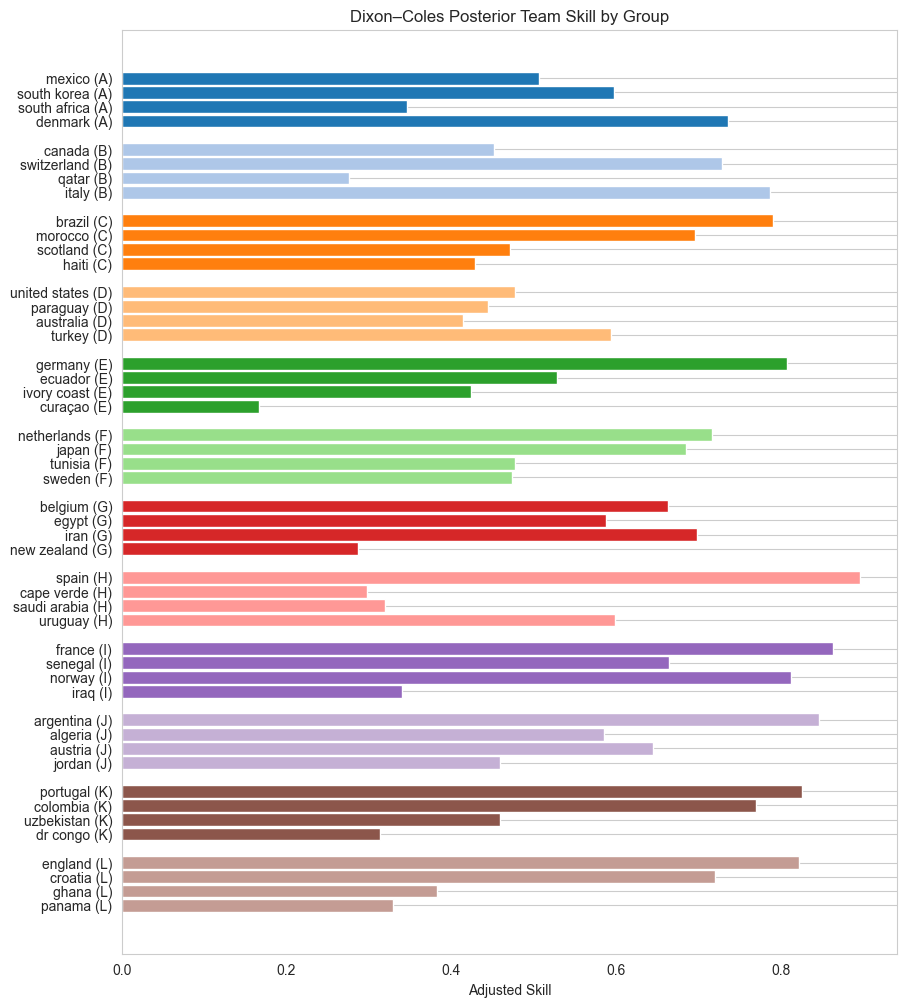

In [7]:
#Plot posterior skills by group
plot_teams, plot_skills, plot_colors, group_positions = [], [], [], []
for i, (group, group_teams) in enumerate(wc.groups.items()):
    color = plt.get_cmap("tab20")(i)
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            plot_teams.append(team)
            plot_skills.append(team_skills_df.set_index("team").loc[team_lower, "skill"])
            plot_colors.append(color)
            group_positions.append(i + j * 0.2)

plt.figure(figsize=(10, 12))
plt.barh(group_positions, plot_skills, color=plot_colors, height=0.18)

yticks, yticklabels = [], []
for i, (group, group_teams) in enumerate(wc.groups.items()):
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            yticks.append(i + j * 0.2)
            yticklabels.append(f"{team} ({group})")

plt.yticks(yticks, yticklabels)
plt.gca().invert_yaxis()
plt.xlabel("Adjusted Skill")
plt.title("Dixon–Coles Posterior Team Skill by Group")
plt.grid(axis="x")
plt.show()

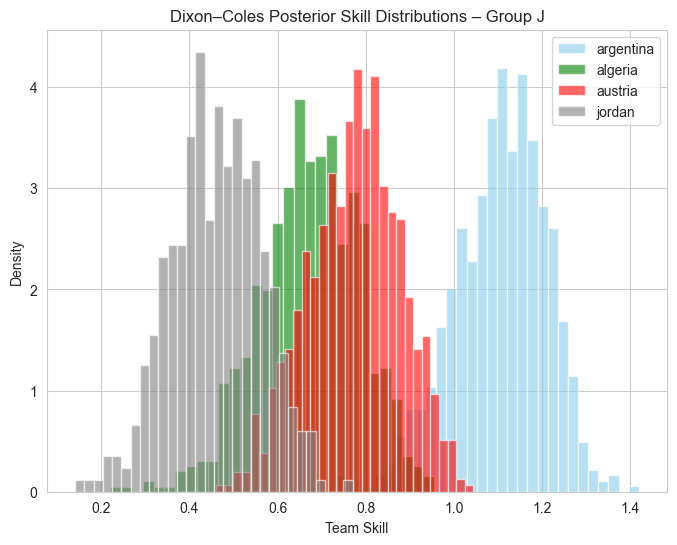

In [8]:
# Posterior distributions example: Group J
group = wc.groups["J"]
colors = ["skyblue", "green", "red", "grey"]

plt.figure(figsize=(8,6))
for i, team in enumerate(group):
    team_lower = team.lower()
    if team_lower not in team_to_idx:
        continue
    idx = team_to_idx[team_lower]

    # Compute skill posterior: attack - mean defense (per posterior sample)
    samples = posterior["attack"][:, idx] - posterior["defense"].mean(dim=1)
    samples = samples.numpy()

    plt.hist(samples, bins=30, alpha=0.6, density=True,
             label=team, color=colors[i])

plt.xlabel("Team Skill")
plt.ylabel("Density")
plt.title("Dixon–Coles Posterior Skill Distributions – Group J")
plt.legend()
plt.show()

In [17]:
def skill_func(team, shrinkage=0.4):
    """
    Returns a single posterior sample of skill for a team,
    adjusted with shrinkage toward priors and average defense.
    """
    idx = team_to_idx[team]

    # Randomly pick a posterior sample
    s = np.random.randint(len(posterior["attack"]))

    # Extract posterior draws for this sample
    attack_sample = posterior["attack"][s].numpy()
    defense_sample = posterior["defense"][s].numpy()
    team_names = [idx_to_team[i] for i in range(n_teams)]

    # Apply shrinkage toward priors
    attack_adj = np.array([
        attack_sample[i] * (1 - shrinkage) + attack_prior.get(team_names[i], 0.5) * shrinkage
        for i in range(n_teams)
    ])
    defense_adj = np.array([
        defense_sample[i] * (1 - shrinkage) + defense_prior.get(team_names[i], 0.5) * shrinkage
        for i in range(n_teams)
    ])

    # Compute skill: adjusted attack minus average defense
    avg_defense = np.mean(defense_adj)
    skill = attack_adj[idx] - avg_defense

    return skill

In [18]:
N = 1000
all_results = defaultdict(list)

for _ in range(N):
    placements = wc.simulate_world_cup(sf=skill_func, verbose=False)
    for team, stage in placements.items():
        all_results[team].append(stage)

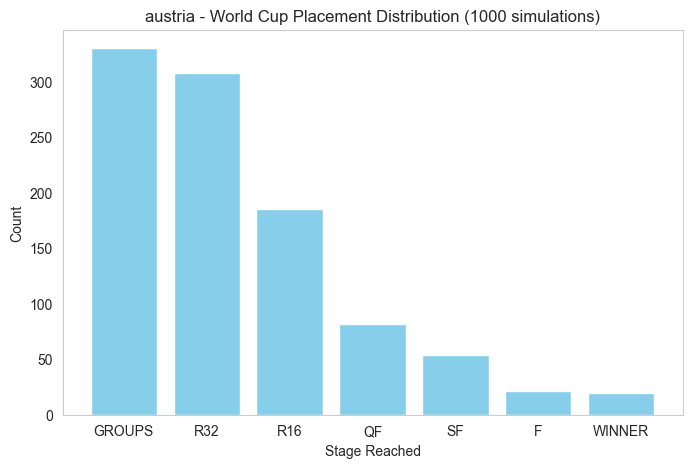

In [19]:
country = "austria"

# count placements
counts = Counter(all_results[country])

# ensure consistent order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']
counts = [counts.get(stage, 0) for stage in stages]

plt.figure(figsize=(8,5))
plt.bar(stages, counts, color='skyblue')
plt.title(country + " - World Cup Placement Distribution (" + str(N) + " simulations)")
plt.ylabel("Count")
plt.grid(False)
plt.xlabel("Stage Reached")
plt.show()

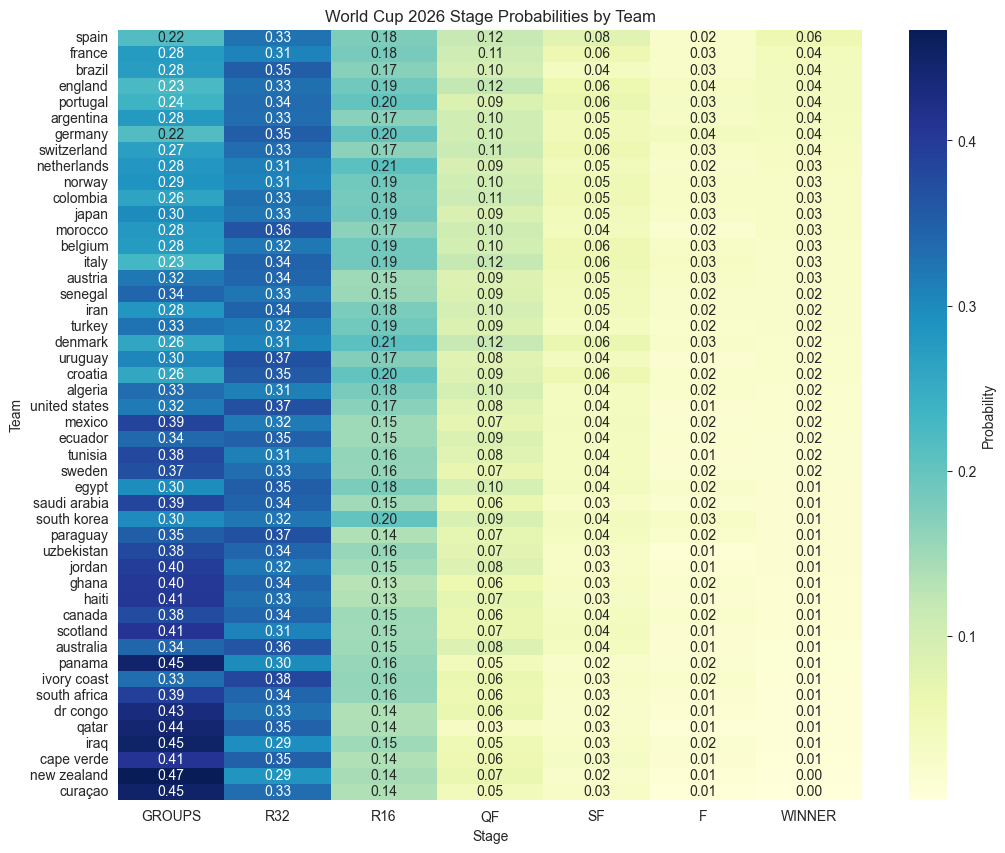

In [12]:
# Define stages in order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']

# Compute stage probabilities for each team
team_stage_probs = {}
for team, results in all_results.items():
    counts = Counter(results)
    team_stage_probs[team] = {stage: counts.get(stage, 0)/len(results) for stage in stages}

# Convert to DataFrame
prob_df = pd.DataFrame(team_stage_probs).T  # Teams as rows
prob_df = prob_df[stages]  # Ensure correct stage order

# Sort teams by probability of reaching WINNER stage
prob_df = prob_df.sort_values("WINNER", ascending=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(prob_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Probability'})
plt.title("World Cup 2026 Stage Probabilities by Team")
plt.ylabel("Team")
plt.xlabel("Stage")
plt.yticks(rotation=0)
plt.show()

In [14]:
N = 1000
winners = []

for _ in range(N):
    # Draw a single posterior sample for all teams
    s = np.random.randint(len(posterior["attack"]))
    skills = {
        team: (posterior["attack"][s, team_to_idx[team]] - posterior["defense"][s].mean()).item()
        for team in wc_teams  # your filtered WC teams in lowercase
    }

    # Simulate one tournament with these skills
    placements = wc.simulate_world_cup(sf=lambda team: skills[team], verbose=False)

    # Append the winner
    for team, stage in placements.items():
        if stage == "WINNER":
            winners.append(team)

# Compute actual probabilities
winner_counts = Counter(winners)
winner_probs = {team: count / N for team, count in winner_counts.items()}

# Sort
winner_probs_sorted = dict(sorted(winner_probs.items(), key=lambda x: x[1], reverse=True))

print("World Cup 2026 Winning Probabilities (N=1000 simulations)")
print("Top 10 teams by chance of winning:\n")
print(f"{'Rank':<4} {'Team':<15} {'Probability':<10}")
print("-" * 32)

for i, (team, prob) in enumerate(list(winner_probs_sorted.items())[:10], 1):
    print(f"{i:<4} {team:<15} {prob:.3f}")

print("-" * 32)

World Cup 2026 Winning Probabilities (N=1000 simulations)
Top 10 teams by chance of winning:

Rank Team            Probability
--------------------------------
1    brazil          0.061
2    spain           0.056
3    france          0.056
4    argentina       0.052
5    belgium         0.041
6    germany         0.040
7    portugal        0.040
8    england         0.035
9    netherlands     0.033
10   italy           0.031
--------------------------------
